# Fleshed out example
NOTE: This notebook is pretty rough. It will development  change during development of the code..

#### Imports

In [2]:
# Useful for plottimg
from matplotlib import pyplot as plt

# Useful for calculations
import numpy as np

# Useful for getting lists of files, etc
import os
import glob

# I use *pickle* to load some external "pickled" datasets. Not necessary for anything else. 
import pickle
# Also use xarray to load some external data
import xarray as xr

# I use *mpl.dates* to enter some dates. Not necessary for anything else. 
from matplotlib import dates
from matplotlib.dates import date2num, num2date

# Useful in development..
import importlib

### Find modules and  files we will work with

In [3]:
# Load the modules

# Changing directories because we need to be in the directory below the functions
# (may make this a bit neater later..)
os.chdir('/home/oyvindl/work/code/git_public/sigpyproc/examples/')
os.chdir('../')
from sigpyproc import sig_load, sig_append, sig_calc, sig_draft
from sigpyproc import sig_open_water_correction, sig_vel, sig_toolbox, sig_append
os.chdir('examples/')

In [4]:
# Make a list of the .mat files we want to load 
floc = '/media/oyvindl/ratatosk/data/mooring_data/signature500/m1_1/converted/*'
flist = glob.glob(floc)
for fn in flist:
    if '_avgd' in fn:
        flist.remove(fn)

## Load the data 

##### Load from matfiles to a neatly xarray Dataset 

- Wraps from a simgle time dimension to *(TIME, SAMPLE)*
- Concatenates the many .mat files to a single file
- Various formatting stuff
- Calculate tilt
- Estimates sea ice presence from FOM (and adds "sea ice concentration" fields)

Specifying lat/lon here - that can also be done later

This step takes a while (a minute or so?).

Throws some errors that I haven't investigated (don't seem to matter but I don't want to suppress them, until I'm sure what they are)

In [5]:
importlib.reload(sig_load)

<module 'sigpyproc.sig_load' from '/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_load.py'>

In [21]:
DX = sig_load.matfiles_to_dataset(flist[:2], lat = 79.589, lon = 28.097)

170640 time points, 3555 ensembles. Sample per ensemble: 48


/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_append.py:270: RuntimeWarning: invalid value encountered in sqrt
  180 / np.pi* np.arccos(np.sqrt(
/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_append.py:279: RuntimeWarning: invalid value encountered in sqrt
  180 / np.pi* np.arccos(np.sqrt(


Done. Run sig_funcs.overview() to print some additional details.


##### Have a quick look at the data 

We can look at the file interactively by just typing "DX".

We can also run *sig_load.overview(DX)* for some very basic statistics.

We can also run *sig_toolbox.histogram(DX, [variable name])* to look at the distribution of a variable 

In [ ]:
sig_load.overview(DX)

## Append some external datasets

We can append external data to *DX* using the *sig_append* module. The functions in the module interpolates external data onto the *TIME* grid.

The function *sig_append.add_to_sigdata* is general and can be used to append whatever can be of use.

There are specified functions for appending specific things that are used in subsequent processing: 

- *sig_append.append_atm_pres*: Append **sea level pressure** (used for depth correction)
- *sig_append.append_ctd*: Append **S, T, P from CTD sensor** (used for density and sound speed corrections)
- *sig_append.set_lat, set_lon*: Add (single-value) **lat/lon** (if it wasn't done in the initial loading step)
- *sig_append.append_magdec*: Add **magnetic declination** (used for correction of velocity directions). 

#### Append atmospheric pressure from CARRA atmospheric reanalysis 

Load a dataset containing sea level pressure.

(I have previously collected these data from CARRA reanalysis).

Note that these should be provided in units of **decibars**.

In [ ]:
with open('../testing/development/CARRA_MSL_M1_temp.p', 'rb') as f:
    dmsl = pickle.load(f)

In [ ]:
carra_m1 = xr.open_dataset('/media/oyvindl/ratatosk/data/carra/selected_points/carra_18_22_M1.nc')

In [ ]:
DX_no_msl = DX.copy()

In [ ]:
# Append to the dataset
DX = sig_append.append_atm_pres(DX, carra_m1.msl.data*1e-4, date2num(carra_m1.time))

We now have a *p_atmo* field in *DX*:
Make a quick plot to check that our interpolation worked:

In [ ]:
fig, ax = plt.subplots(figsize = (8, 3))
ax.plot_date(dmsl.time, dmsl.MSL, '-', label = '(Daily) data loaded from .p file')
ax.plot(carra_m1.time, carra_m1.msl*1e-4, '-', label = 'Hourly, from nc file')
ax.plot(DX.TIME, DX.p_atmo, ':', label = 'Data from .nc interpolated to TIME grid')

ax.legend()
ax.set_ylabel('Decibar')
ax.set_xlim(dmsl.time[300], dmsl.time[310])

#### Append CTD data
Next, we add data from a CTD sensor that was mounted rigth below the Signature. We will use it to improve our sound speed and density estimates - it is also interesting to includefor analysis purposes!

In [ ]:
# Load data (which I have prepared in advance)

with open('../testing/development/CARRA_CTD_M1_1_temp.p', 'rb') as f:
    dctd = pickle.load(f)
    
# Chop away nan ends..
ctd_sl = slice(3, -3)
for key in dctd.keys():
    dctd[key] = dctd[key][ctd_sl]

In [ ]:
# Append to the dataset
# (Specifying serial number and description is optional!)
DX = sig_append.append_ctd(DX, dctd.TEMP, dctd.SP, dctd.pres, dctd.time,
             instr_SN = '11111', 
           instr_desc = 'RBR Concerto CTD sensor mounted right below the Signature' )

The *append_ctd* function read T/S/p variables. These were converted to TEOS-10 using the *gsw* module. It also calculated sound speed and density.

We therefore have some new fields in DX, all with the suffix *_CTD*: *SA_CTD, CT_CTD, sound_speed_CTD..*. The descriptions we prescribed, as well as other metadata such as units and full name, should be available in the variable attributes, e.g.:

In [ ]:
DX.SA_CTD

#### Append magnetic declination

In this case, we know that the declination only changes by <0.5 degrees over the deployment. For now, we are happy using a linear interpolation based two values we found for two points in time (from the EMM, extracted using this online calculator: https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm)

In [ ]:
mag_time = [dates.date2num(dates.datetime.date(2018, 9, 1)), 
            dates.date2num(dates.datetime.date(2019, 9, 1))]
magdec = [19.7683447942, 20.1825371364]

In [ ]:
# Append to DX (the attributes are not necessary - 
# but it's a good idea to keep track of this sort 
# of stuff in the file metadata!)

DX = sig_append.append_magdec(DX, magdec, mag_time, 
         attrs = {'note':('Magdec interpolated between extracted from EMM, '
              'extracted using this online calculator: '
              'https://www.ngdc.noaa.gov/geomag/calculators/magcalc.shtml#igrfwmm')})

In [ ]:
# Inspect magdec in DX
DX.magdec

Note that the append_magdec *extrapolates*. Let's look at the actual values: 

In [ ]:
fig, ax = plt.subplots(figsize = (8, 2))
ax.plot(DX.TIME, DX.magdec, label = 'DX.magdec')
ax.plot_date(mag_time, magdec, 'o', label = 'Original points')
ax.legend()
ax.set_ylabel('Degrees')

#### Add AMSR2 SIC

Adding SIC is not necessary for anything. But it is an example of a information that can be useful to include for analysis - remote sensing SIC is also useful for comparing the SIC we have computed from in-situ data! 

In [ ]:
# Load previously extracted data
sic = xr.open_dataset('/home/oyvindl/work/projects/sig500/data/misc/sic/M1M2_AMSR2_SIC.nc')
sic_data = sic.SIC_m1
sic_time = sic.time+0.5 # We add half a day because the daily time stamp is at 00:00

In [ ]:
# 'SIC_AMSR2' specified what we want this variable to be called. A name is mandatory,
# "attrs" specifies attributes/metedata info. Not necessary but useful!
DX = sig_append.add_to_sigdata(DX, sic_data, sic_time, 'SIC_AMSR2', 
               attrs = {'long_name':'AMSR2 UoB sea ice concentration',
        'description':'SIC extracted from the nearest grid point.',
        'sourcefile':'/home/oyvindl/work/projects/sig500/data/misc/sic/M1M2_AMSR2_SIC.nc'})

In [ ]:
# inspect:
DX.SIC_AMSR2

##### Quick look and comparison with "in situ SIC" 
In the *sig_load.matfiles_to_dataset* call in the beginning, we calculated ice presence uring the *FOM* metric, and estimated "SIC" based on this. 

Below we do a quick comparison with the remote sensing SIC that we just added.

Note: We use the function *sig_calc.daily_median* to calculate daily medians

In [ ]:
for nn in list(DX.keys()):
    print(nn)

In [ ]:
fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(DX.TIME, DX.SIC_AMSR2, 'k', zorder = 20, lw = 1, label ='AMSR2 SIC (nearest cell)')
ax.plot(DX.TIME, DX.SIC_FOM, color = 'r', alpha = 0.1)
SIC_FOM_dat, td = sig_calc.daily_average(DX.SIC_FOM, DX.TIME, function = 'mean')
ax.plot(td+0.5, SIC_FOM_dat, color = 'r', alpha = 1, label = 'SIC_FOM (daily)')
SIC_FOM_ALT_dat, td = sig_calc.daily_average(DX.SIC_FOM_ALT, DX.TIME, function = 'mean')
ax.plot_date(td+0.5, SIC_FOM_ALT_dat, '-', color = 'g', alpha = 1, 
             lw = 1, label = 'SIC_FOM_ALT (daily)')
ax.legend()

ax.set_ylabel('Concentration [%]');

-> Looks pretty good!

### Calculate depth
Before we calculate ice drafts and velocities, we want to compute the instrument depth $h$. This is done from a hydrostatic approximation  $$h = \frac{p}{\rho g}$$

Where $p$ is the ocean pressure (*Average_AltimeterPressure*) where we have added back the in-build atmospheric correction, but *subtracted* our the time-varying atmopheric pressure that we added earlier (*p_atmo*).  

$\rho$ is density from CTD (*rho_CTD*) and $g$ is (latitude-dependent) gravitational acceleration calculated using the function *gsw.grav*.

It is possible to calculate depth without atmospheric pressure, in-situ density etc. The function uses everything that is available unless we specify *corr_atmo=False* or *corr_CTD_density=False* in the function call. 

In [ ]:
# Doing one calculation withotu the TD densioty correction to see if there is a difference..

DX = sig_calc.dep_from_p(DX, corr_CTD_density=True)

DX0 = DX.copy()
DX0 =sig_calc.dep_from_p(DX0, corr_CTD_density=False)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 3))
ax.plot(DX.TIME, (DX0.depth- DX.depth).mean(dim='SAMPLE')*1e2, )
ax.set_ylabel('[cm]')
ax.set_title('Difference in depth after applying in-situ CTD (vs fixed rho = 1027 kg m-3)')
meandiff = float((DX0.depth-DX.depth).mean())*1e2
ax.plot([float(DX.TIME[0]), float(DX.TIME[-1])], np.ones(2)*meandiff, ':k', label = 'Mean')
ax.legend(); ax.grid()

As we see, the *note* field details which corrections have been applied. 

**A quick sanity check:** we should have $depth\sim~0$ after the instrument was brought on board

In [ ]:
fig, ax = plt.subplots(figsize = (8, 2))
ax.plot(DX.TIME, DX.depth.mean(dim = 'SAMPLE'))#, label = 'DX.magdec')

#ax.plot_date(mag_time, magdec, 'o', label = 'Original points')
ax.set_ylabel('m')
ax.set_xlim(DX.TIME[-20], DX.TIME[-1])
ax.set_ylim(-0.1, 0.1)
ax.grid()
ax.set_title('Instrument "depth" at the end of deployment')

-> Yep, we are about 3 cm off which **seems pretty good.**

### Chopping away on-ship measurements
We actually don't want to include the measurements taken on deck or after/during deployments. We can easily chop everything using the function *sig_load.chop*:

In [ ]:
# Good starting point: Just call the function and follow the prompts. 
DX = sig_load.chop(DX)

We have now chopped away the time on deck durign the recovery, reducing the size of the dataset a bit.

Note that this information is preserved in *DX.history* attribute 

In [ ]:
print(DX.history)

# Draft

We are now ready to calculate the sea ice draft. The basic approach is:

1. Calculate depth of the scattering surface from depth/tilt/sound/speed/altimeter distance.
    - All valid values (open water and ice) are stored as *SURFACE_DEPTH_*
    - Only values during estimated sea ice presence are stored as *SEA_ICE_DRAFT_*
2. Extract a time-varying "open water correction" forcing the long-time moving average open water values to be near zero.
    - Calculate a sound speed correction factor $\beta$ which would make the necessary correction to the open water values.
3. Repeat step 1, but now applying the sound speed $\beta$ to the distance calculation.

##### Step 1: Initial calculation of surface depths


In [ ]:
DX = sig_draft.calculate_draft(DX)

We have now added a bunch of new fields to *DX* (e.g. *SURFACE_DEPTH_LE*, *SEA_ICE_DRAFT_AST*..).

Note that We do the calculation - separately - for both the *AST* and *LE* altimeter estimates. 

For the *LE* estimate (which typically is better/less noisy, but detects "false keels" near the transducer), we **drop all LE samples where AST and LE disagree by > 0.5 m**. In this case that means dropping a *lot* of samples (something like 1/3 of the dataset), but the hope is that it gives a better estimate.

In [ ]:
DX.SURFACE_DEPTH_AST

##### Step 2: Open water correction
*(Note: this can take a minute or so to run)*

(Describe this here in more detailed later..) 

In [ ]:
# Step 2: Open water correc
DX = sig_open_water_correction.get_Beta_from_OWSD(DX)

### Find sound speed correction Beta

In [ ]:
# Running with the default parameters for now..
DX = sig_open_water_correction.get_Beta_from_OWSD(DX)

*Note*: We have **not** made any adjustments to the draft yet - just estimated $\beta$ (added as the *BETA_open_water_corr_* fields). 

We can examine the correction now to see if we are happy with it using teh *compare_OW_correction* funcion:
(This function is bulky and should be made more practical)

In [ ]:
sig_open_water_correction.compare_OW_correction(DX)

So we can see that we make a larger adjustment  for LE than (eq to ~18 cm) for AST (eq to ~4 cm).

Will look into this a bit later - but for now we will assume that we are happy with out $beta$, and recompute the draft:

### Recompute draft

In [ ]:
DX = sig_draft.calculate_draft(DX)

We have now updated the calculation to include oue $\beta$,m which should improve the estimate and bring open water values nearer to zero.

if we look at the *SEA_ICE_DRAFT_* and *SURFACE_DEPTH_* fields we should see that this is now specified in the metadata (the *note* field).

##### Quick histogram
We can use the *sig_toolbox.histogram* function for a quick look at the results (also shows the attributes including the *note* field)

In [ ]:
sig_toolbox.histogram(DX, 'SEA_ICE_DRAFT_MEDIAN_LE', nbins = 150)

In [ ]:
fig, ax = plt.subplots( figsize = (10, 3))
hkws = {'density':True, 'bins':335, 'range':(-0.5, 6.2), 'alpha':0.5}
ax.hist((DX.SEA_ICE_DRAFT_LE).values.flatten(), **hkws, label = 'LE');
ax.hist((DX.SEA_ICE_DRAFT_AST).values.flatten(), **hkws, label = 'AST');
ax.legend()

In [ ]:
# Compare SD
mean_sd_LE = float(DX.SEA_ICE_DRAFT_LE.std(dim = 'SAMPLE').mean())
mean_sd_AST = float(DX.SEA_ICE_DRAFT_AST.std(dim = 'SAMPLE').mean())
print('Mean SD across samples:')
print('AST: %.2f cm'%(1e2*mean_sd_AST))
print('LE: %.2f cm'%(1e2*mean_sd_LE))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
ax[0].hist((DX.SEA_ICE_DRAFT_LE-DX.SEA_ICE_DRAFT_AST).values.flatten(), 100);
ax[1].hist((DX.SEA_ICE_DRAFT_MEDIAN_LE-DX.SEA_ICE_DRAFT_MEDIAN_AST).values, 100);

**TO DO**

- Continue through with ice velocity. (**X**?)
    - Processing + diagnosis
- Ocean velocity can be prioritised down for now..
- Include chopping functions (**X**?)
- Include save to nc functions
- Make static page for git

## Ice velocity

The ice drift velocity calculation is simpler, consisting of:

- Loading the velocities: *uice, vice* from *AverageIce_VelEast/_VelNorth*
- Applying a quality criterion requiring FOM<10 000 for all 4 beams (equivalent to requiring *ICE_IN_SAMPLE==True*)
    - Rejecting all samples where this does not hold 
- Calculate ensemble median values *Uice, Vice* (default is to use medians, can also use means).
   - Also creating *Uice_SC, Vice_SD* - containing the ensemble standard deviation. 
- Rotate the current vectors to account for magnetic declination.
  - Applied to both *uice* and *Uice*. (Also applying to ocean velocities now..)

##### Create the ice uv fields 

In [ ]:
DX = sig_ice_vel.calculate_drift(DX)

.. we have now added *uice, vice, Uice, Vice, Uice_SD, Vice_SD* to *DX*.

We can compare *uice* with the original *AverageIce_VelEast* field to see what out FOM cleaning has done:

In [ ]:
DX.TIME[9000].data

In [ ]:
ax[1].get_xlim()

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (11, 4))
for axn in ax:
    axn.plot(DX.TIME, DX.AverageIce_VelEast.isel(SAMPLE=0), '.', alpha = 0.3,label= 'AverageIce_VelEast (first in each sample) ')
    axn.plot_date(DX.TIME, DX.uice.isel(SAMPLE=0), '-', label= 'uice (first in each sample) ')
    axn.set_ylabel('m/s')
    axn.legend(ncol = 2, fontsize = 8, loc = 4)
ax[1].set_xlim(num2date(DX.TIME[12000]), num2date(DX.TIME[13000]))
ax[1].text(0.1, 0.8, 'ZOOMED', fontsize = 20, fontweight = 'bold', transform=ax[1].transAxes)

##### Inspect
The function *sig_toolbox.plot_ellipse_icevel* is useful to get a quick look at the ice velocity data. It shows the u/v spread, mean and low-passed velocity, and the variance ellipse (of the low-passed currents)

In [ ]:
sig_toolbox.plot_ellipse_icevel(DX);

### Rotating for magnetic declination

Earlier, we added the *magdec* field to *DX*. We can now use it to rotate the ice velocity vectors:

In [ ]:
DX = sig_ice_vel.rotate_vels_magdec(DX)

The declination is about 20 degrees, so we should expect a CW rotation of the **u** vectors by about 20 degrees. Check this by using *plot_ellipse_icevel* again: 

In [ ]:
sig_toolbox.plot_ellipse_icevel(DX);

--> OK. 

Note that some metadata has been added to the velocity fields, e.g.:

In [ ]:
DX.Uice.attrs

## Ocean velocities (TBW)

In [243]:
DX = sig_load.matfiles_to_dataset(flist[:2], lat = 79.589, lon = 28.097)

170640 time points, 3555 ensembles. Sample per ensemble: 48
Done. Run sig_funcs.overview() to print some additional details.


/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_append.py:270: RuntimeWarning: invalid value encountered in sqrt
  180 / np.pi* np.arccos(np.sqrt(
/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_append.py:279: RuntimeWarning: invalid value encountered in sqrt
  180 / np.pi* np.arccos(np.sqrt(


In [244]:
DX = sig_calc.dep_from_p(DX)

WARNING!
Could not find atmospheric pressure (*p_atmo*) - not recommended continue if you plan to compute ice draft. 
--> (To add *p_atmo*, run sig_append.append_atm_pres()=

Depth calculation: Abort (A) or Continue (C): c
Continuing without atmospheric correction (careful!)..

No density (*rho_ocean*) field found. 
Enter "A" (Abort) or "C" (Continue using fixed rho = 1027 kg m-3): c
Continuing using fixed rho. Choose: 
(R): Use rho = 1027 kg m-3, or
(S): Specify fixed rho
r
Continuing with fixed rho = 1027.0 kg m-3


In [297]:
importlib.reload(sig_vel)

<module 'sigpyproc.sig_vel' from '/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_vel.py'>

In [298]:
DX = sig_vel._calculate_bin_depths(DX)

In [299]:
DX.depth.dims

('TIME', 'SAMPLE')

In [300]:
DX = sig_vel.calculate_ocean_vel(DX)

In [301]:
DX.uocean

<xarray.DataArray 'uocean' (BINS: 16, TIME: 3555, SAMPLE: 48)>
array([[[-2.17000008e-01, -3.00000003e-03, -2.40000002e-02, ...,
         -2.11000010e-01, -2.26000011e-01, -5.40000014e-02],
        [ 7.20000044e-02, -2.30000019e-02,  1.56000003e-01, ...,
         -6.20000027e-02, -8.00000057e-02, -1.90000013e-02],
        [-3.50000001e-02, -6.90000057e-02, -1.60000008e-02, ...,
         -1.75000012e-01, -1.53000012e-01, -3.20000015e-02],
        ...,
        [ 9.43000019e-01, -3.00000012e-01, -3.20000023e-01, ...,
          8.47000062e-01,  8.87000024e-01,  1.74000010e-01],
        [ 1.03000008e-01, -1.70000009e-02,  4.60000038e-02, ...,
          1.03000008e-01, -2.36000016e-01,  2.81000018e-01],
        [ 1.18900001e+00, -8.22000027e-01,  2.73000002e-01, ...,
         -1.41200006e+00,  9.57000017e-01, -1.17200005e+00]],

       [[-9.60000008e-02, -2.00000014e-02, -1.35000005e-01, ...,
         -1.18000008e-01, -2.82000005e-01, -1.93000004e-01],
        [-1.00000007e-02, -9.90000069e-02, -5.80000021e-02, ...,
         -7.70000070e-02, -1.10000007e-01,  1.00000001e-01],
        [-1.27000004e-01, -1.03000008e-01, -1.60000011e-01, ...,
         -1.20000005e-01, -1.54000014e-01, -6.59999996e-02],
...
         -2.49300003e+00,  5.32000005e-01, -5.73000014e-01],
        [-7.11000025e-01,  2.43000016e-01,  1.67000011e-01, ...,
          9.42000031e-01,  1.13100004e+00, -2.05800009e+00],
        [ 1.23200011e+00,  2.75100017e+00, -4.66000021e-01, ...,
         -1.20000005e-01, -1.00999999e+00, -4.35000032e-01]],

       [[ 1.24700010e+00,  6.39000058e-01, -2.55000025e-01, ...,
          3.36000025e-01,  5.02000034e-01, -2.34000012e-01],
        [ 5.96000016e-01, -2.40000002e-02, -5.00000007e-02, ...,
         -1.04900002e+00,  2.07000017e-01,  5.57000041e-01],
        [-1.56500006e+00,  1.89400005e+00,  1.67000011e-01, ...,
          1.51000008e-01,  8.38000059e-01,  2.19000012e-01],
        ...,
        [-1.08200002e+00, -1.90900004e+00,  2.10000016e-02, ...,
          1.23400009e+00, -2.68000007e-01, -1.23300004e+00],
        [-4.53000009e-01, -6.18000031e-01, -3.06000024e-01, ...,
          5.06000042e-01, -2.80000009e-02, -1.11800003e+00],
        [ 6.97000027e-01, -2.02400017e+00,  6.64000034e-01, ...,
          1.10800004e+00, -1.47300005e+00, -1.80600011e+00]]],
      dtype=float32)
Coordinates:
  * BINS     (BINS) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * TIME     (TIME) float64 1.781e+04 1.781e+04 ... 1.822e+04 1.822e+04
  * SAMPLE   (SAMPLE) int64 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48
Attributes:
    units:               m s-1
    long_name:           Eastward ocean velocity
    details:             All average mode samples
    processing_history:  Loaded from Average_VelEast/Average_VelEast fields.\n

In [302]:
DX.depth.dims

('TIME', 'SAMPLE')

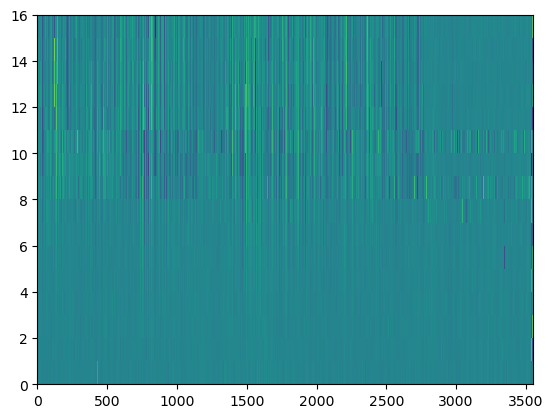

In [303]:
fig, ax = plt.subplots()
ax.pcolormesh(DX.uocean.isel(SAMPLE=1))

In [304]:
d = DX['uocean']

In [314]:
importlib.reload(sig_vel)
DX = sig_vel._uvoc_mask_range(DX)

In [311]:
DX = sig_append.append_magdec(DX, 20.69)

In [317]:
DX = sig_vel.rotate_vels_magdec(DX)

('uocean', 'vocean')
Declination correction rotation has been applied to something before. 
 -> Continue (1) or skip new correction (0): 1
-> Applying new correction.


AttributeError: 'Dataset' object has no attribute '_calculate_uvocean_avg'

In [321]:
importlib.reload(sig_vel)


<module 'sigpyproc.sig_vel' from '/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_vel.py'>

In [322]:
DX = sig_vel.rotate_vels_magdec(DX)

Declination correction rotation has been applied to something before. 
 -> Continue (1) or skip new correction (0): 1
-> Applying new correction.


In [324]:
DX.declination_correction

'!! NOTE !! Magnetic declination correction has been applied more than once - !! CAREFUL !!\n!! NOTE !! Magnetic declination correction has been applied more than once - !! CAREFUL !!\n!! NOTE !! Magnetic declination correction has been applied more than once - !! CAREFUL !!\nMagdec declination correction rotation applied to: \n - (uocean, vocean)'

In [294]:
DX.uocean.processing_history

'Loaded from Average_VelEast/Average_VelEast fields.\n\nTHRESHOLD_BASED DATA CLEANING : \nStart: 2730240 initial valid samples.\nDropping (NaNing samples where):\n- # Speed < 1.50 ms-1 # -> Dropped 288608 pts (10.57%)\n- # Tilt < 5.00 deg # -> Dropped 4508 pts (0.18%)\n- # Sound sp in [1400, 1560] ms-1 # -> Dropped 0 pts (0.00%)\n- # Corr (all beams) < 60.0 % # -> Dropped 58580 pts (2.40%)\n- # Amp (all beams) in [30, 85] db # -> Dropped 166514 pts (7.00%)\n- # Above amp bumps > 20 db # -> Dropped 806370 pts (36.45%)\nEnd: 1405660 valid samples.\nRotated CW by an average of 20.69 degrees to correct for magnetic declination. \nRotated CW by an average of 20.69 degrees to correct for magnetic declination. \nRotated CW by an average of 20.69 degrees to correct for magnetic declination. \n'

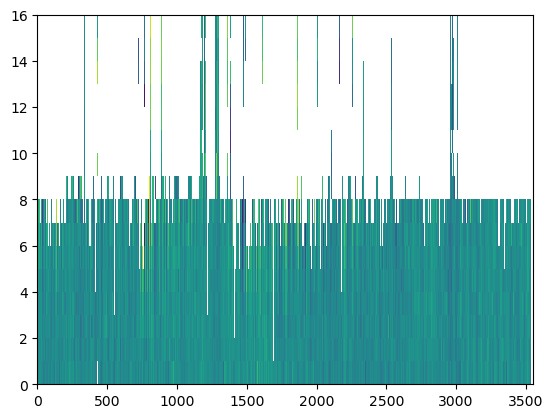

In [235]:
fig, ax = plt.subplots()
ax.pcolormesh(DX.uocean.isel(SAMPLE=1))

In [159]:
DX.depth.dims

('TIME', 'SAMPLE')

In [141]:
DX

2212030.0

In [120]:
importlib.reload(sig_vel)

<module 'sigpyproc.sig_vel' from '/home/oyvindl/work/code/git_public/sigpyproc/sigpyproc/sig_vel.py'>

In [ ]:
DX.ti

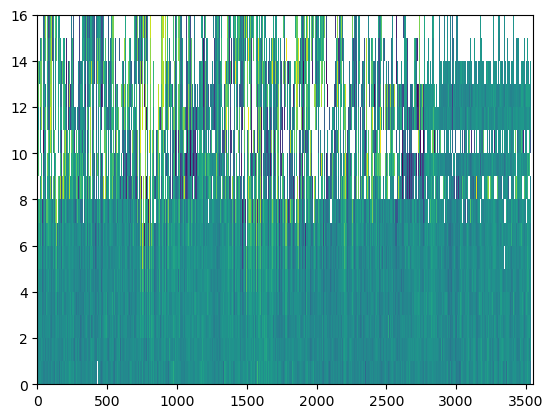

In [ ]:
DX.bin_depth

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
          3182.,  15196.,  27164.,  41476.,  61353.,  95092., 245047.,
        826266., 542794., 145884.,  79936.,  53670.,  36405.,  23318.,
         12608.,   2639.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

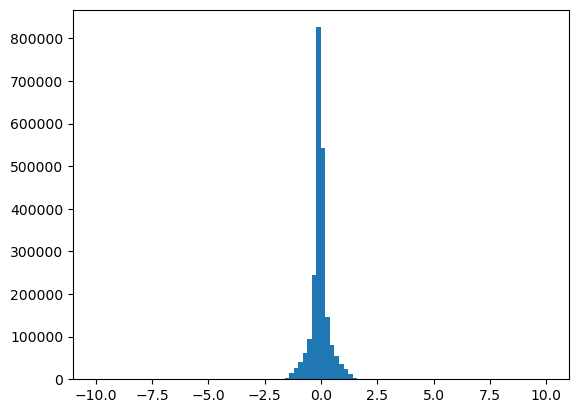

In [160]:
fig, ax = plt.subplots()
ax.hist(DX.tilt_Average.data.flatten(), 100, range = (-10, 10))

In [52]:
DX.AverageIce_VelUp2.min()

<xarray.DataArray 'AverageIce_VelUp2' ()>
array(-11.10964, dtype=float32)

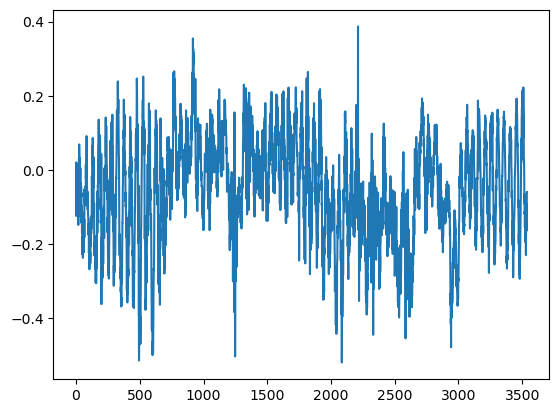

In [61]:
fig, ax = plt.subplots()
ax.plot(DX.Average_VelNorth.mean(dim = 'SAMPLE').mean(dim = 'BINS'))
#ax.plot(DX.Average_VelUp2.mean(dim = 'SAMPLE').mean(dim = 'BINS'))
#ax.plot(DX.ICE_IN_SAMPLE.mean(dim = 'SAMPLE').mean(dim = 'BINS'))


In [74]:
max_amp_increase = 20

In [178]:
    # Amplitude bump test
    is_bump = (
        (DX.Average_AmpBeam1.diff(dim = 'BINS')>max_amp_increase)
        | (DX.Average_AmpBeam2.diff(dim = 'BINS')>max_amp_increase)
        | (DX.Average_AmpBeam3.diff(dim = 'BINS')>max_amp_increase)
        | (DX.Average_AmpBeam4.diff(dim = 'BINS')>max_amp_increase))

In [179]:
(is_bump.cumsum(axis = 0)>0).shape

(15, 3555, 48)

In [183]:
zeros_firstbin.shape

(3555, 48)

In [189]:
zeros_firstbin = xr.zeros_like(DX.uocean.isel(BINS=1))
IS_BUMP = xr.concat([zeros_firstbin, is_bump.cumsum(axis = 0)>0], dim = ('BINS'))

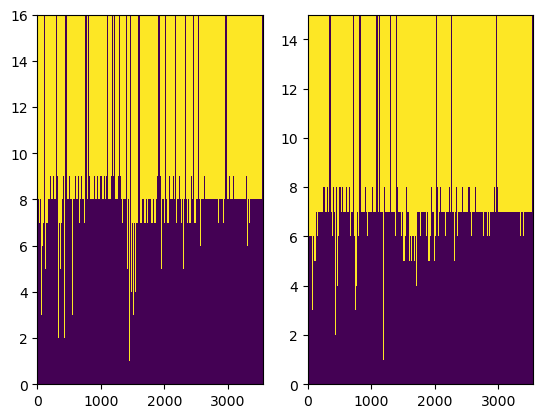

In [194]:
figm, ax = plt.subplots(1, 2)
ax[0].pcolormesh(IS_BUMP.isel(SAMPLE=1).T)
ax[1].pcolormesh((is_bump.cumsum(axis = 0)>0).isel(SAMPLE=1))

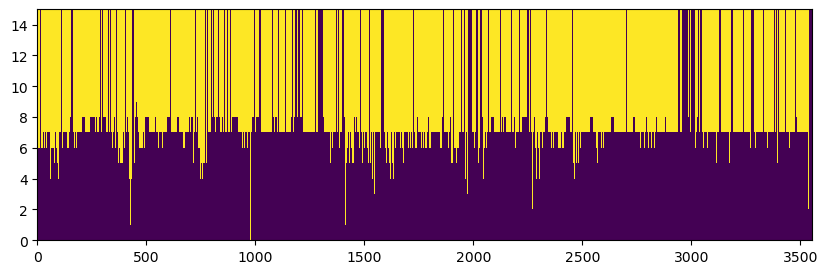

In [88]:
fig, ax = plt.subplots(figsize = (10, 3))
ax.pcolormesh((is_bump.cumsum(axis = 0)>0).isel(SAMPLE=1))

In [72]:
DX.Average_AmpBeam3.diff(dim = 'BINS')

<xarray.DataArray 'Average_AmpBeam3' (BINS: 15, TIME: 3555, SAMPLE: 48)>
array([[[ -3.5,  -6.5,  -7. , ...,  -5. ,  -7. ,  -4. ],
        [ -8.5,  -7.5, -10. , ...,  -7.5,  -6.5,  -7.5],
        [-12. ,  -9. ,  -6.5, ...,  -5. , -10.5,  -7.5],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[ -7. ,  -6. ,  -6.5, ...,  -4. ,  -7.5,  -5.5],
        [ -3. ,  -3.5,  -6. , ...,  -4.5,  -5.5,  -1.5],
        [ -0.5,   1. ,  -3. , ...,  -7. ,  -3.5,  -5. ],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[ -2. ,  -2.5,  -1. , ...,  -5.5,   0. ,  -3. ],
        [ -4.5,  -1. ,  -1.5, ...,  -0.5,  -2.5,   1. ],
        [ -4. ,  -5. ,  -3.5, ...,  -0.5,  -2. ,   1. ],
        ...,
...
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[  nan,   nan,  -2.5, ...,   nan,  -6. ,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [ -4.5,  -7.5,   nan, ...,   nan,  -7.5,   nan],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]],

       [[  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [ -6.5,   nan,   nan, ...,   nan,  -6.5,   nan],
        ...,
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]]], dtype=float32)
Coordinates:
  * BINS     (BINS) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * TIME     (TIME) float64 1.781e+04 1.781e+04 ... 1.822e+04 1.822e+04
  * SAMPLE   (SAMPLE) int64 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48

In [67]:
DX.dims

Frozen({'TIME': 3555, 'SAMPLE': 48, 'BINS': 16, 'beams': 4, 'xyz': 3})

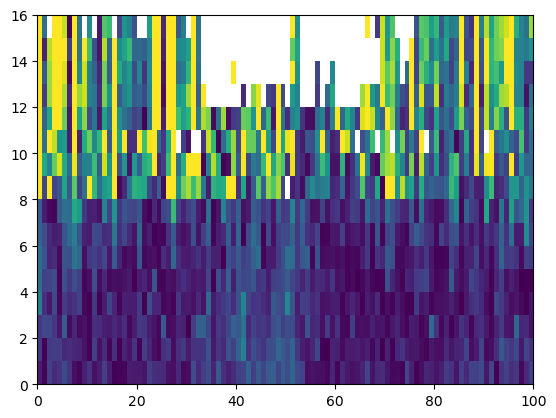

In [65]:
fig, ax = plt.subplots()
ax.pcolormesh(np.sqrt(DX.Average_VelNorth[:, 1000:1100, 0]**2 + DX.Average_VelNorth[:, 1000:1100, 0]**2), 
             vmin = 0, vmax = 1.5)

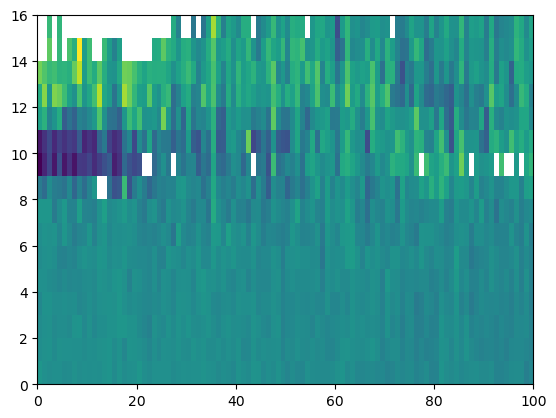

In [33]:
fig, ax = plt.subplots()
ax.pcolormesh(DX.Uocean[:, :100, 0])

## Exporting

In [ ]:
sig_load.overview(DX)

In [ ]:
DX

In [ ]:
sig_load.to_nc(DX, 'testfile.nc', export_vars= ['SIC_FOM'], icedraft = True, icevel = True, oceanvel = False)

#### Read the testfile..

In [ ]:
TF = xr.open_dataset('testfile.nc')

In [ ]:
TF.attrs.conf

In [ ]:
TF.close()